## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

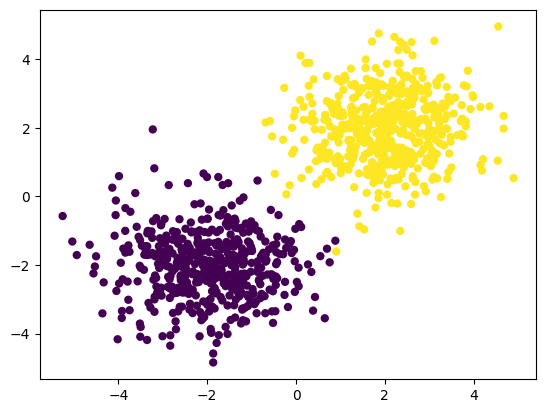

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

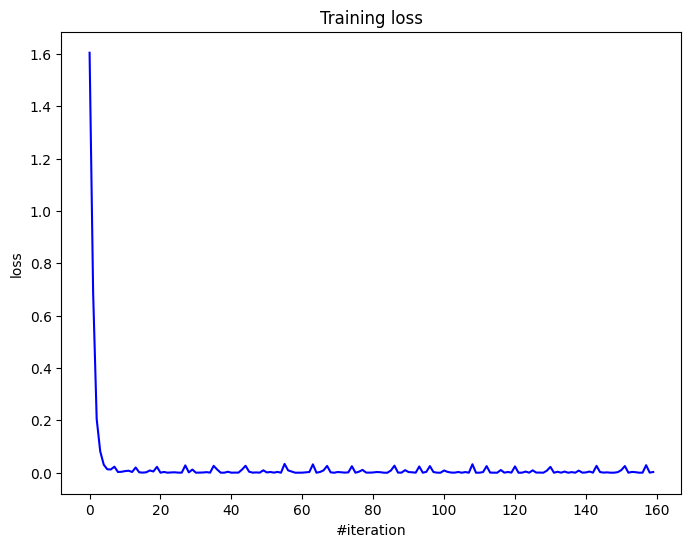

Current loss: 0.002818


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [50]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
valset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)

val_size = int(len(valset) * 0.5)
test_size = len(valset) - val_size
valset, testset = torch.utils.data.random_split(valset, [val_size, test_size])

X_train = trainset.data.numpy().reshape((len(trainset), -1))
y_train = trainset.targets.numpy()
X_val = valset.dataset.data[valset.indices].numpy().reshape((len(valset), -1))
y_val = valset.dataset.targets[valset.indices].numpy()
X_test = testset.dataset.data[testset.indices].numpy().reshape((len(testset), -1))
y_test = testset.dataset.targets[testset.indices].numpy()

One-hot encode the labels first.

In [51]:
from sklearn.preprocessing import OneHotEncoder

X_train = np.expand_dims(X_train, 1)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)

encoder = OneHotEncoder(categories='auto')

y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

X_train, X_val, X_test = list(map(lambda x: x.reshape((x.shape[0], -1)), [X_train, X_val, X_test]))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [10]:
from sklearn.metrics import accuracy_score
optimizer_config = {'learning_rate' : 3e-4, 'beta1': 0.95, 'beta2': 0.95, 'epsilon': 1e-5}
optimizer_state = {}

n_epoch = 20
batch_size = 128

0it [00:00, ?it/s]

469it [00:15, 31.19it/s]
469it [00:08, 55.02it/s] 
469it [00:05, 84.57it/s] 
469it [00:06, 75.26it/s] 
469it [00:06, 77.91it/s] 
469it [00:04, 97.77it/s] 
469it [00:05, 91.13it/s] 
469it [00:05, 85.53it/s] 
469it [00:04, 94.16it/s] 
469it [00:04, 93.95it/s] 
469it [00:06, 76.24it/s] 
469it [00:05, 89.92it/s] 
469it [00:04, 98.27it/s] 
469it [00:10, 44.29it/s] 
469it [00:06, 70.26it/s] 
469it [00:05, 88.97it/s] 
469it [00:04, 96.28it/s] 
469it [00:04, 95.62it/s] 
469it [00:05, 91.32it/s] 
469it [00:04, 97.93it/s] 
469it [00:05, 84.12it/s] 
469it [00:06, 76.39it/s] 
469it [00:06, 72.96it/s] 
469it [00:05, 82.08it/s] 
469it [00:05, 82.28it/s] 
469it [00:05, 84.15it/s] 
469it [00:05, 87.77it/s] 
469it [00:06, 69.75it/s] 
469it [00:05, 85.96it/s] 
469it [00:05, 84.01it/s] 
469it [00:07, 65.13it/s] 
469it [00:05, 91.36it/s] 
469it [00:05, 86.04it/s] 
469it [00:05, 83.46it/s] 
469it [00:05, 85.94it/s] 
469it [00:05, 91.30it/s] 
469it [00:05, 84.02it/s] 
469it [00:05, 81.35it/s] 
469it [00:05,

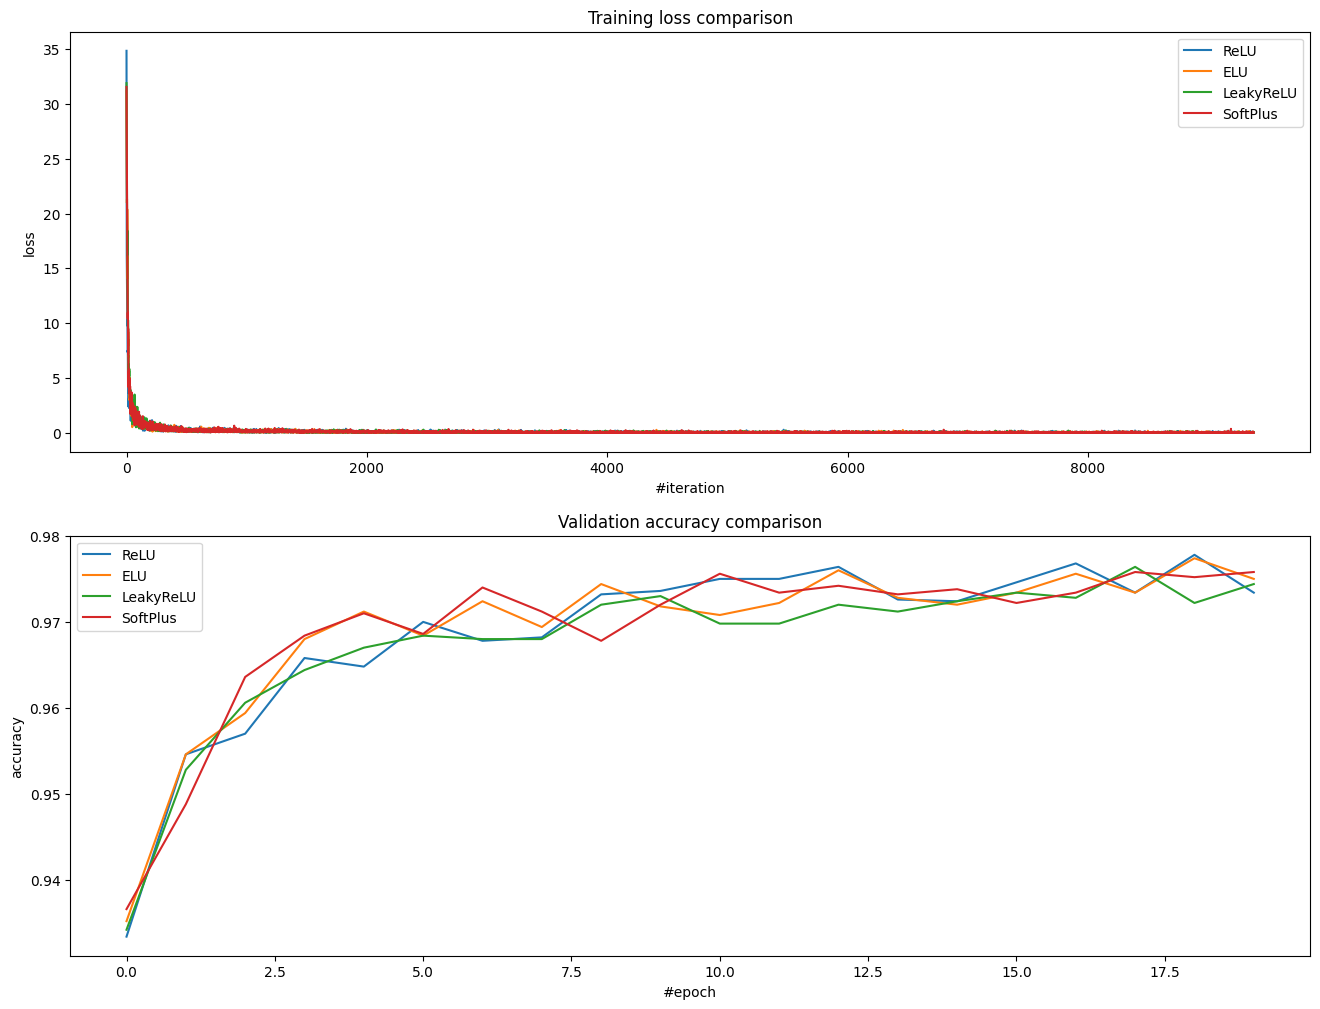

In [13]:
activation_functions = [ReLU(), ELU(), LeakyReLU(), SoftPlus()]
activation_names = ['ReLU', 'ELU', 'LeakyReLU', 'SoftPlus']

loss_histories = {}
accuracy_histories = {}

for activation, name in zip(activation_functions, activation_names):
    net = Sequential()
    net.add(Linear(784, 128))
    net.add(activation)
    net.add(Linear(128, 10))
    net.add(LogSoftMax())

    criterion = ClassNLLCriterion()

    loss_history = []
    accuracy_history = []

    for i in range(n_epoch):
        net.train()
        for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size)):
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            net.zeroGradParameters()
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            adam_optimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)

        net.evaluate()
        accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))

    loss_histories[name] = loss_history
    accuracy_histories[name] = accuracy_history

plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
plt.title("Training loss comparison")
plt.xlabel("#iteration")
plt.ylabel("loss")
for name, history in loss_histories.items():
    plt.plot(history, label=name)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Validation accuracy comparison")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
for name, history in accuracy_histories.items():
    plt.plot(history, label=name)
plt.legend()

plt.show()

0it [00:00, ?it/s]

469it [00:05, 80.57it/s] 
469it [00:05, 86.74it/s] 
469it [00:05, 80.55it/s] 
469it [00:05, 83.75it/s] 
469it [00:05, 84.78it/s] 
469it [00:05, 86.48it/s] 
469it [00:05, 86.67it/s] 
469it [00:05, 84.33it/s] 
469it [00:05, 86.10it/s] 
469it [00:05, 88.58it/s] 
469it [00:05, 89.20it/s] 
469it [00:05, 84.52it/s] 
469it [00:05, 87.73it/s] 
469it [00:05, 88.53it/s] 
469it [00:05, 87.41it/s] 
469it [00:05, 86.56it/s] 
469it [00:05, 85.03it/s] 
469it [00:05, 86.18it/s] 
469it [00:05, 83.26it/s] 
469it [00:05, 86.98it/s] 
469it [00:06, 70.83it/s]
469it [00:06, 70.58it/s]
469it [00:06, 77.75it/s]
469it [00:06, 70.59it/s]
469it [00:06, 73.03it/s]
469it [00:06, 72.58it/s]
469it [00:06, 77.21it/s]
469it [00:06, 75.22it/s]
469it [00:06, 70.46it/s]
469it [00:06, 75.56it/s]
469it [00:06, 68.83it/s]
469it [00:07, 61.14it/s]
469it [00:06, 76.50it/s]
469it [00:06, 74.05it/s]
469it [00:05, 79.29it/s]
469it [00:06, 76.50it/s]
469it [00:06, 76.04it/s]
469it [00:06, 74.55it/s]
469it [00:06, 75.12it/s]
469it

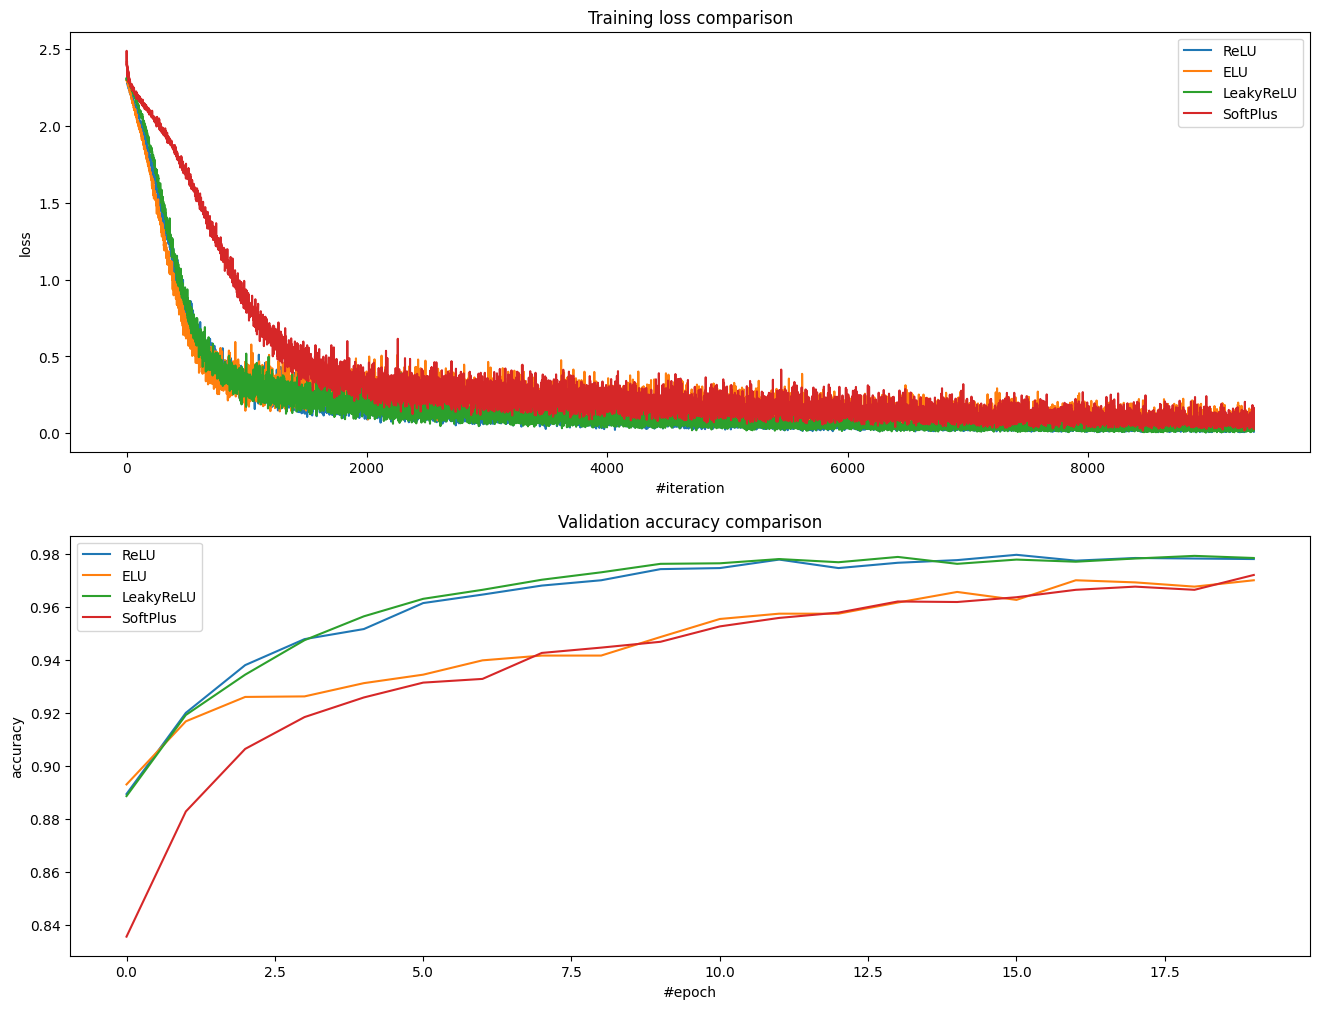

In [19]:
activation_functions = [ReLU(), ELU(), LeakyReLU(), SoftPlus()]
activation_names = ['ReLU', 'ELU', 'LeakyReLU', 'SoftPlus']

loss_histories = {}
accuracy_histories = {}

for activation, name in zip(activation_functions, activation_names):
    net = Sequential()
    net.add(Linear(784, 128))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(128))
    net.add(activation)
    net.add(Linear(128, 10))
    net.add(LogSoftMax())

    criterion = ClassNLLCriterion()

    loss_history = []
    accuracy_history = []

    for i in range(n_epoch):
        net.train()
        for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size)):
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            net.zeroGradParameters()
            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            adam_optimizer(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)

        net.evaluate()
        accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))

    loss_histories[name] = loss_history
    accuracy_histories[name] = accuracy_history

plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
plt.title("Training loss comparison")
plt.xlabel("#iteration")
plt.ylabel("loss")
for name, history in loss_histories.items():
    plt.plot(history, label=name)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Validation accuracy comparison")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
for name, history in accuracy_histories.items():
    plt.plot(history, label=name)
plt.legend()

plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################
"""
On such small net, BatchNorm acts more as a regularization tool, producing more stable (and slower) training.
ReLU and its modification produce better results with normalized model, probably because of their characteristic of preserving scaling of data.
Without BatchNorm, all functions perform similarly, though ReLU definition makes computation very efficient.
Also, using BatchNorm, different beta and batch sizes affected performance very much.
"""

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

469it [00:03, 124.10it/s]
469it [00:03, 120.09it/s]
469it [00:03, 119.08it/s]
469it [00:04, 111.32it/s]
469it [00:03, 124.27it/s]
469it [00:03, 119.91it/s]
469it [00:03, 118.83it/s]
469it [00:03, 123.91it/s]
469it [00:04, 117.11it/s]
469it [00:03, 127.80it/s]
469it [00:04, 110.81it/s]
469it [00:03, 118.80it/s]
469it [00:03, 119.29it/s]
469it [00:03, 122.36it/s]
469it [00:03, 125.30it/s]
469it [00:03, 121.47it/s]
469it [00:03, 121.20it/s]
469it [00:03, 118.96it/s]
469it [00:03, 126.66it/s]
469it [00:04, 101.05it/s]
469it [00:03, 120.81it/s]
469it [00:04, 108.68it/s]
469it [00:03, 120.04it/s]
469it [00:03, 123.43it/s]
469it [00:03, 120.12it/s]
469it [00:03, 122.61it/s]
469it [00:04, 115.98it/s]
469it [00:05, 92.49it/s] 
469it [00:03, 121.16it/s]
469it [00:03, 117.62it/s]
/tmp/ipykernel_518/784725612.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()

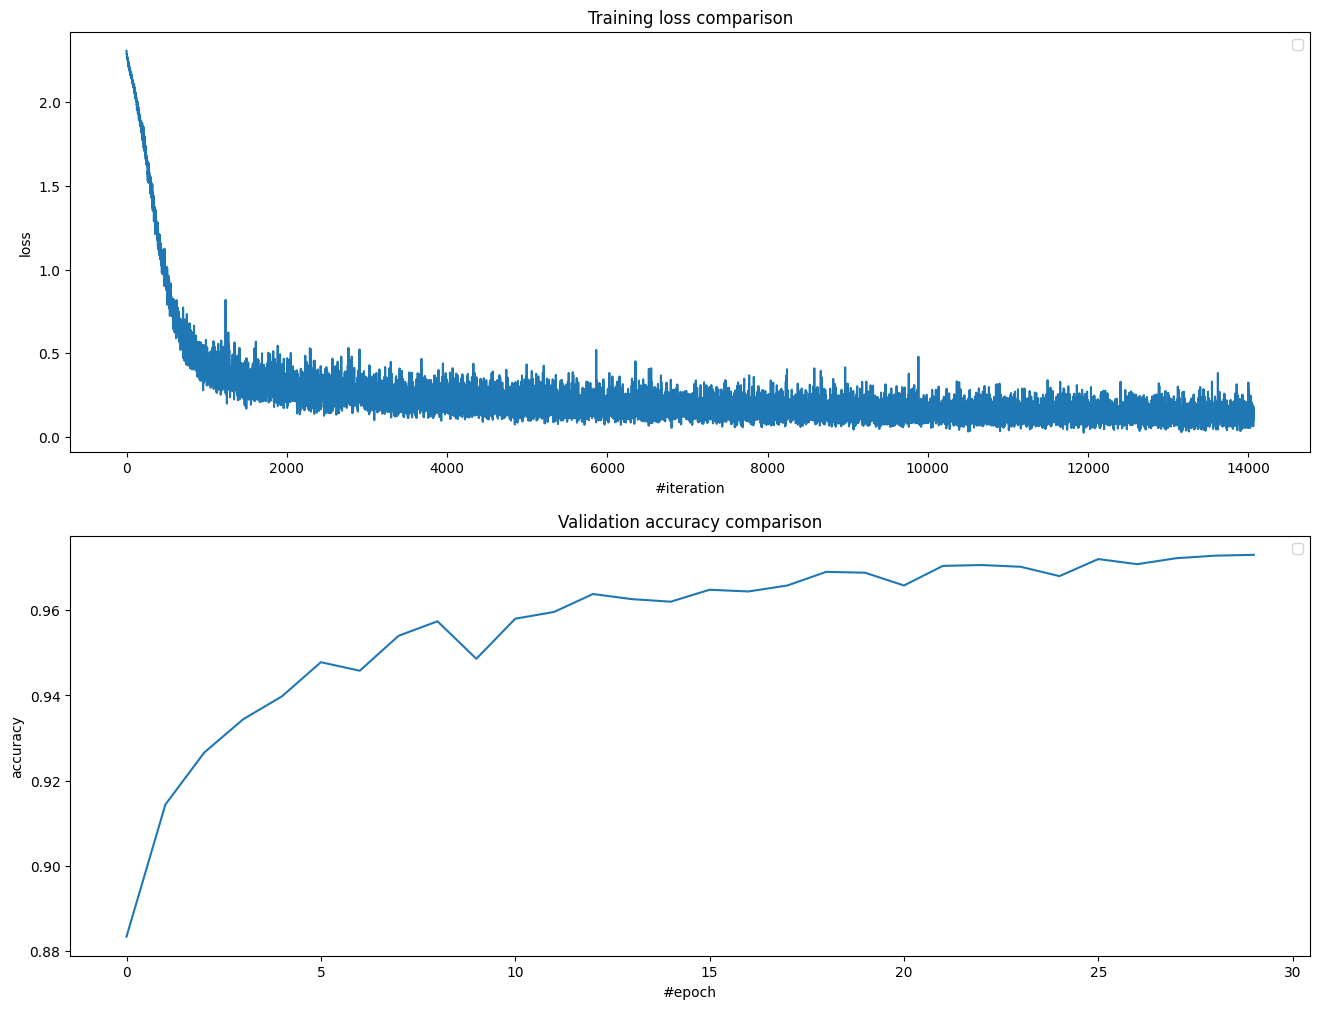

In [11]:
optimizer_config = {'learning_rate' : 3e-4, 'beta1': 0.95, 'beta2': 0.95, 'epsilon': 1e-5}
optimizer_state = {}

n_epoch = 30
batch_size = 128

loss_history = []
accuracy_history = []

net = Sequential()
net.add(Linear(784, 128))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(128))
net.add(ReLU())
net.add(Dropout())
net.add(Linear(128, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()


loss_history = []
accuracy_history = []

for i in range(n_epoch):
    net.train()
    for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size)):
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        net.zeroGradParameters()
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        adam_optimizer(net.getParameters(), 
                        net.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)      

        loss_history.append(loss)

    net.evaluate()
    accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))


plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
plt.title("Training loss comparison")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Validation accuracy comparison")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(accuracy_history)
plt.legend()

plt.show()

Print here your accuracy on test set. It should be around 90%.

In [19]:
accuracy_score(y_test, np.argmax(net.forward(X_test), axis=1))

0.9714

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


/tmp/ipykernel_518/3909025264.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_518/3909025264.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


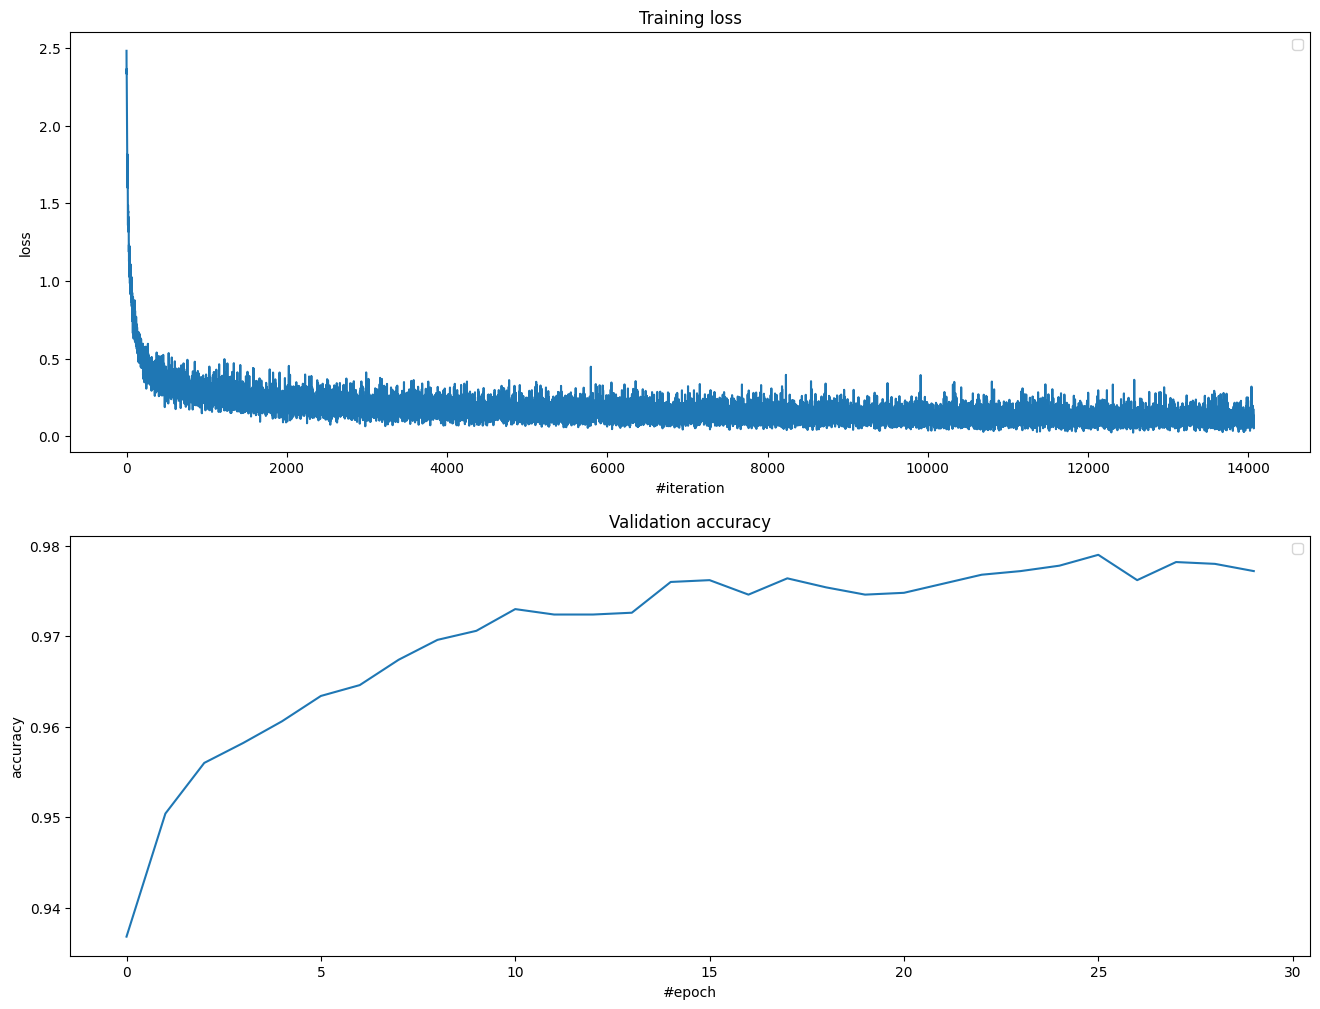

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

optimizer_config = {'learning_rate' : 3e-4, 'beta1': 0.95, 'beta2': 0.95, 'epsilon': 1e-5}

n_epoch = 30
batch_size = 128

loss_history = []
accuracy_history = []

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

net = Net()
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=optimizer_config['learning_rate'],
                        betas=(optimizer_config['beta1'], optimizer_config['beta2']),
                          eps=optimizer_config['epsilon'])


train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.argmax(axis=1), dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

loss_history = []
accuracy_history = []

for epoch in range(n_epoch):
    net.train()

    for x_batch, y_batch in train_loader:
        predictions = net(x_batch)
        loss = criterion(predictions, y_batch)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    net.eval()
    correct = 0
    total = 0
    preds, labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            predictions = net(x_batch).argmax(dim=1)
            preds.extend(predictions.numpy())
            labels.extend(y_batch.numpy())
    accuracy_history.append(accuracy_score(labels, preds))

    print(f"Epoch {epoch + 1}/{n_epoch}")

plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history)
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Validation accuracy")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(accuracy_history)
plt.legend()

plt.show()

In [52]:
X_test = torch.tensor(X_test, dtype=torch.float32)
accuracy_score(y_test, net(X_test).argmax(dim=1))

0.974